<h1> Text Analyses on Reddit posts from the Ukrain and Russian war </h1>

First we import our dependencies

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# train-test split
from sklearn.model_selection import train_test_split

# loss functions for today
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# stuff for evaluating classifiers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt # for displaying a pretty confusion matrix


# dummy models for comparison
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


Count vectorization involves turning a collection of text documents into a matrix of token counts.

In other words, count vectorization means using every observed token (word) across the entire corpus as an attribute (column) and, for each document (row), tallying up how many times each token is observed.

We first need to import the data and inspect it.

In [2]:
df1 = pd.read_csv('./hot_posts.csv')
df2 = pd.read_csv('./top_posts.csv')
df3 = pd.read_csv('./controversial_posts.csv')
df4 = pd.read_csv('./new_posts.csv')
dfMerge = [df1, df2, df3, df4]
df = pd.concat(dfMerge)
df.dropna(subset=['score'], inplace=True)
df.dropna(subset=['title'], inplace=True)
df.drop(df[df['score'] > 4000].index, axis=0, inplace=True)
df

,title,score,id,subreddit,url,num_comments,body,created
20,Ukrainian servicemen meeting up with Family me...,49,y3kiqk,RussiaUkraineWar2022,https://v.redd.it/e32gpxjidpt91,4,NaN,1.665723e+09
21,Recent footage of Ukrainian destruction on a R...,80,y3ggjp,RussiaUkraineWar2022,https://v.redd.it/pwg9eqa4eot91,8,NaN,1.665712e+09
22,Standard.,299,y361jw,RussiaUkraineWar2022,https://i.redd.it/pdc92smg9mt91.jpg,18,NaN,1.665686e+09
23,Members of the Ukrainian military active in th...,239,y381ts,RussiaUkraineWar2022,https://v.redd.it/fff9anqhnmt91,6,NaN,1.665690e+09
24,Fires in Belgorod region now.,413,y332bw,RussiaUkraineWar2022,https://v.redd.it/h682swesnlt91,32,NaN,1.665678e+09
...,...,...,...,...,...,...,...,...
976,Lieutenant Sergei Didorenko & Senior Lieutenan...,228,xvp4c8,RussiaUkraineWar2022,https://www.reddit.com/gallery/xvp4c8,20,NaN,1.664914e+09
977,Ukrainian forces blew up a Russian ammo cache ...,153,xvp2i0,RussiaUkraineWar2022,https://v.redd.it/3xd2ekcthur91,7,NaN,1.664914e+09
978,Ka-52 pilot Captain Aleksey Belonozhko has bee...,304,xvp1gi,RussiaUkraineWar2022,https://i.redd.it/t6sxzwxlhur91.jpg,17,NaN,1.664914e+09
979,Current frontlines according to Michael McKay,148,xvp0x9,RussiaUkraineWar2022,https://www.reddit.com/gallery/xvp0x9,17,NaN,1.664914e+09


As we can see, there are Titles and Scores. We want to predict if certain words (x) give a high score (Y).

Now we Vectorise this data so that the model can read it as 1's and 0's (i.e., a list of all the tokens/words present) and inspect term frequencies.)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(df["title"])

CountVectorizer()

We then print the vocabulary for the vect we created and check for the amount of words.

In [4]:
vocab_size = len(vect.vocabulary_)

print("Number of vocab before post prossesing: {:.3f}".format(vocab_size))  # 3

Number of vocab before post prossesing: 6964.000


<h1> Preprosessing </h1>

We start by removing all low-frequency words. (code adapted from https://stackoverflow.com/questions/57179045/how-to-remove-less-frequent-words-from-pandas-dataframe)

In [5]:
input_text = df["title"]

# Set the threshold for the minimum number of occurrences, in this case 3
all_ = [x for y in input_text for x in y.split(' ') ]
a, b = np.unique(all_, return_counts = True)
to_remove = a[b < 3]

# Remove the low-frequency words from the "title" column
df["title"] = [' '.join(np.array(y.split(' '))[~np.isin(y.split(' '), to_remove)])
                for y in input_text]

We need to clean this list so that our model only has meaningful words to work with.

One way of doing this is by <strong style="color:red">removing stopwords</strong>.

To do this we can use the ```nltk``` library, which provides a list of stop words for various languages.

In [6]:
import nltk

# Download the list of stop words
nltk.download('stopwords')
nltk.download('punkt')

# Get the list of stop words for the English language
stop_words = nltk.corpus.stopwords.words('english')

# Tokenize the text in the 'text' column
df['title'] = df['title'].apply(nltk.word_tokenize)

# Define a function to remove stop words from a list of tokens
def remove_stop_words(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

# Apply the function to the 'text' column of the dataframe
df['title'] = df['title'].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Seb_R\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Seb_R\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We check to see if the code has removed the stop words

In [7]:
print(df['title'])

20             [Ukrainian, servicemen, meeting, members]
21     [Recent, footage, Ukrainian, destruction, Russ...
22                                         [Standard, .]
23     [Members, Ukrainian, military, active, Kherson...
24                          [Fires, Belgorod, region, .]
                             ...                        
976    [Lieutenant, Sergei, &, Senior, Lieutenant, Vl...
977    [Ukrainian, forces, blew, Russian, ammo, back,...
978    [Ka-52, pilot, Captain, Aleksey, killed, Ukrai...
979            [Current, frontlines, according, Michael]
980    [Russian, Commander, tank, company, ,, neutral...
Name: title, Length: 3688, dtype: object


As we can see, code has removed the stopwords from our dataframe.

We can now focus on removing low-frequency words to help simplify our dataframe for our model and rerun the count vectorizer to continue building our model.

an array of strings is what the CountVectorizer expects. Therefore, it will crash if we pass in a nested array of tokens. We therefore need to transform the dataframe before vectorizing it.

While vectorizing the data we tell the model to ignore tokens/words that appear in fewer than ```min_def``` amount of reddit posts. Having a high value will reduce processing time while a low value might improve accuracy. After trial and error, we've found 25 gives the best results.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=25)

df["title"] = df["title"].map(' '.join)

vect.fit(df["title"])

CountVectorizer(min_df=25)

In [9]:
vocab_size = len(vect.vocabulary_)

print("Number of vocab before stop-word after post processing: {:.3f}".format(vocab_size))  # 3

Number of vocab before stop-word after post processing: 199.000


This means that we have removed a lot of words to make our model simplere and hopefully more precise.

We transform this data to an array

In [10]:
Title_text = df["title"]

vector = vect.transform(Title_text)
print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
vector.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [12]:
array = vector.toarray()[0]
inv_voc = {v: k for k, v in vect.vocabulary_.items()}
print([inv_voc[x] for x in np.where(array > 1)[0]])

[]


We use the following code to identify which tokens/words occurred more than once in the sample text.

The code prints a list of terms that have a non-zero count in the vectorized data by finding the indices in the array where the count is greater than 1 and using the inv_voc dictionary to map those indices to the corresponding terms. The ```np.where(array > 1)[0]``` expression returns the indices of the array where the condition is true, and the list comprehension ```[inv_voc[x] for x in np.where(array > 1)[0]]``` maps those indices to the corresponding terms in the vocabulary.

<h1> Splitting the data </h1>

We now need to create the test data and split it into text_test and text_train. We are only looking at the titles.

In [13]:
X = vector.toarray()
y = df['score']

In [14]:
sum(X[0])

2

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11122)

We then check to see if the X_train and X_test data contains the same amount of columns but with different amounts of rows.

In [16]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [17]:
X_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Both X_test and X_train have the same amount of columns -> <strong>2,177</strong>

We also check to see if the code has done a good split of the y-test data

In [18]:
y_test

260     975
563     164
961     118
502    1183
417     135
       ... 
806     121
529    1150
626    1043
809     921
182     425
Name: score, Length: 922, dtype: int64

In [19]:
y_train

303     942
188    1785
466     142
221     426
303    1457
       ... 
370    1355
435     193
927      12
150     118
164      21
Name: score, Length: 2766, dtype: int64

We can now run the regression models to see som results

<h1> Results without preprossesing </h>

<img src="Results before pre.png">

<h1> Results after preprossesing </h1>

In [20]:
ranreg = RandomForestRegressor()
ranreg.fit(X_train,y_train)

#Saves the prediction as an object to use for model evaluation
rfpred = ranreg.predict(X_test)

print("Training set score: {:.3f}".format(ranreg.score(X_train, y_train)))
print("Test score: {:.5f}".format(ranreg.score(X_test, y_test)))

Training set score: 0.685
Test score: 0.13028


In [21]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)

#Saves the prediction as an object to use for model evaluation
lgpred = linreg.predict(X_test)

print("Training set score: {:.3f}".format(linreg.score(X_train, y_train)))
print("Test score: {:.5f}".format(linreg.score(X_test, y_test)))

Training set score: 0.186
Test score: 0.07811


In [22]:
kreg = KNeighborsRegressor()
kreg.fit(X_train,y_train)

kregpred = kreg.predict(X_test)

print("Training set score: {:.3f}".format(kreg.score(X_train, y_train)))
print("Test score: {:.5f}".format(kreg.score(X_test, y_test)))

Training set score: 0.279
Test score: 0.02696


In [23]:
#Defines a dummy regressor and fits it to the training data

dm = DummyRegressor(strategy='mean')
dm.fit(X_train,y_train)

dm_y_pred = dm.predict(X_test)
print("Score on training set: {:.3f}".format(dm.score(X_train, y_train)))
print("Score on test set: {:.3f}".format(dm.score(X_test, y_test)))

Score on training set: 0.000
Score on test set: -0.000


In [24]:
# Creates dataframe containing the MSE for each model

MSEs = {'Model':['Dummy', 'LG', 'KREG', 'RF'],
        'MSE':[mean_squared_error(y_test, dm_y_pred),
               mean_squared_error(y_test, lgpred),
               mean_squared_error(y_test, kregpred),
               mean_squared_error(y_test, rfpred)]}

df = pd.DataFrame(MSEs)
df.sort_values(by=['MSE'])

,Model,MSE
3,RF,409455.335956
1,LG,434016.116963
2,KREG,458097.869892
0,Dummy,470793.921511


In [25]:
# Creates dataframe containing the MAE for each model

MAEs = {'Model':['Dummy', 'LR', 'KNN', 'RF'],
        'MAE':[mean_absolute_error(y_test, dm_y_pred),
               mean_absolute_error(y_test, lgpred),
               mean_absolute_error(y_test, kregpred),
               mean_absolute_error(y_test, rfpred)]}

df = pd.DataFrame(MAEs)
df.sort_values(by=['MAE'])

,Model,MAE
3,RF,431.603819
1,LR,478.835374
2,KNN,491.310412
0,Dummy,527.455909


<h1> Tweaking the Hyperprametters </h1>

By looking at the 3 results above, we see that all the models are highly inaccurate and that the <strong style="color:red">Random Forrest Regressor</strong> yields the most accurate results but that <strong style="color:red">KNeighbor Regression and Linear Regression</strong> had the largest increase in accuracy from the preprocessing. We will try to tweak all the parameters to create a more accurate result.


<b></b>


<h2> Random Forest Regressor </h2>

We know that the model is overfitting already, so increasing the number of trees in the forest, will most likely not improve the accuracy.

Therefore, we will start by tweaking the hyperparameters to get a more accurate result.
To tune the hyperparameters of our regression model, we will use the RandomizedSearchCV class from the scikit-learn library. This class allows us to define a range of hyperparameters to search over, and it will automatically evaluate a random sampling of combinations of these hyperparameters to find the best performing set of parameters.

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Create a Random Forest Regressor model
model = RandomForestRegressor()

# Define the hyperparameter distribution
param_distributions = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a random search object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=10, cv=5, n_jobs=-1, random_state=42, verbose=2)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print(random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


Now that we know what hyperparameters that best fit our data, we'll use this to try and improve the results of our model.

In [29]:
from sklearn.ensemble import RandomForestRegressor

# Create an instance of the RandomForestRegressor class
model = RandomForestRegressor()

# Set the hyperparameters of the model
model.n_estimators = 100  # Number of trees in the forest
model.max_depth = None  # Maximum depth of the tree
model.min_samples_split = 5  # Minimum number of samples required to split a node
model.min_samples_leaf = 2

model.fit(X_train,y_train)

#Defines prediction as an object to use for model evaluation
rfpred2 = model.predict(X_test)

print("Training set score: {:.3f}".format(model.score(X_train, y_train)))
print("Test score: {:.5f}".format(model.score(X_test, y_test)))

Training set score: 0.480
Test score: 0.13065


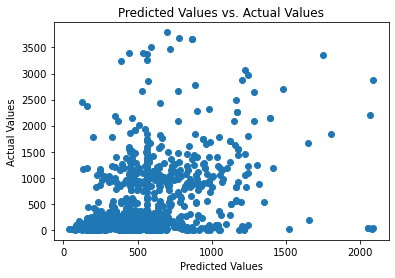

In [30]:
import matplotlib.pyplot as plt

# Make predictions on the test data
predictions = model.predict(X_test)

# Plot the predicted values versus the actual values
plt.scatter(predictions, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted Values vs. Actual Values')
plt.show()

<h2>KNeighbor Regression</h2>

We'll also search on the best parameters on KNeightborsRegression since it had the largest improvement on the before and after the data preprocessing. First we'll search for the right parameters.

In [33]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Create a KNN Regressor model
model = KNeighborsRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 13, 88, 89, 90, 91, 92, 93, 94, 95],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

# Create a grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

Fitting 5 folds for each of 78 candidates, totalling 390 fits
{'n_neighbors': 95, 'p': 2, 'weights': 'distance'}


We'll then check to see if these parameters give a better result.

In [35]:
import mglearn

# Create an instance of the KNeighborRegressor class
model = KNeighborsRegressor()

# Set the hyperparameters of the model
model.n_neighbors = 95  # Number of neighbors
model.p = 2  #
model.weights = 'distance'  #

model.fit(X_train,y_train)

#Defines prediction as an object, to use for model evaluation
kregpred2 = model.predict(X_test)

print("Training set score: {:.3f}".format(model.score(X_train, y_train)))
print("Test score: {:.5f}".format(model.score(X_test, y_test)))

Training set score: 0.764
Test score: 0.22172


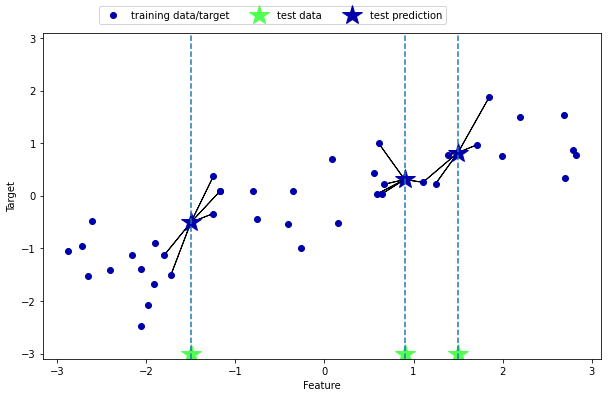

In [36]:
mglearn.plots.plot_knn_regression(n_neighbors=5)

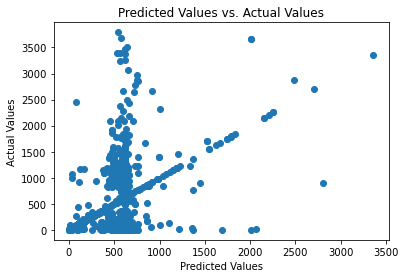

In [37]:
import matplotlib.pyplot as plt

# Make predictions on the test data
predictions = model.predict(X_test)

# Plot the predicted values versus the actual values
plt.scatter(predictions, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted Values vs. Actual Values')
plt.show()

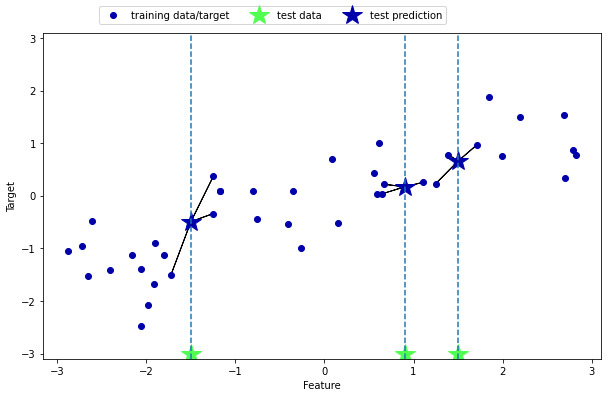

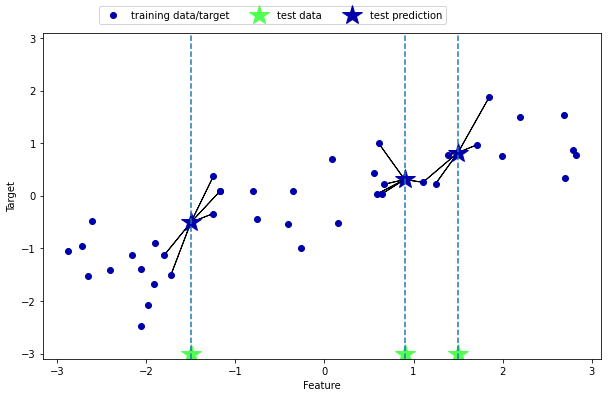

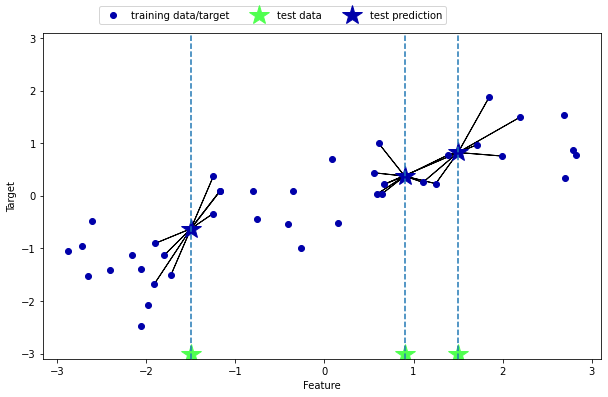

In [38]:
import mglearn
import matplotlib.pyplot as plt

mglearn.plots.plot_knn_regression(n_neighbors=3)
mglearn.plots.plot_knn_regression(n_neighbors=5)
mglearn.plots.plot_knn_regression(n_neighbors=8)

<h2>Linear Regression</h2>

We'll also check for Linear Regression. First we'll check for the best hyperparameters.

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Create a parameter grid to search for the best hyperparameters
param_grid = {'fit_intercept': [True, False],
              'positive': [True, False]}

# Create a linear regression model
model = LinearRegression()

# Create a GridSearchCV object to search for the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'fit_intercept': True, 'positive': False}


Then we'll check if these parameters can give a better result.

In [40]:
# Create an instance of the LinearRegression class
model = LinearRegression()

# Set the hyperparameters of the model

model.fit_intercept = True
model.positive = False

model.fit(X_train,y_train)

#Defines prediction as an object
lgpred2 = model.predict(X_test)

print("Training set score: {:.3f}".format(model.score(X_train, y_train)))
print("Test score: {:.5f}".format(model.score(X_test, y_test)))

Training set score: 0.186
Test score: 0.07811


Let's check how many different words our model used as inputs.

In [41]:
feature_names = np.array(vect.get_feature_names_out())
len(feature_names)

199

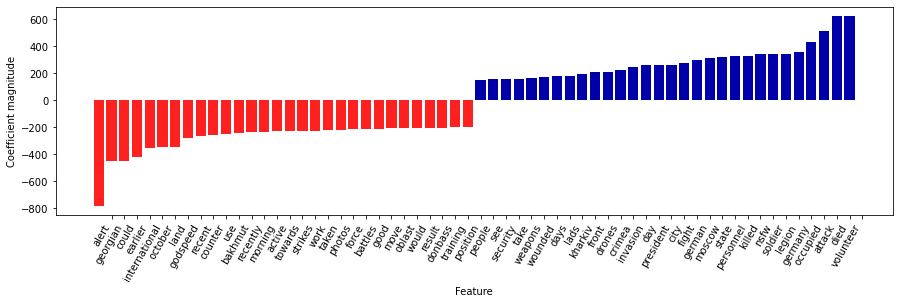

In [42]:
import mglearn

mglearn.tools.visualize_coefficients(
        model.coef_,
        feature_names, n_top_features=30)

<h1> Evaluating the regression models using MSE, MAE & RSME </h1>

In [43]:
# Creates dataframe containing the MSE for each model

MSEs = {'Model':['Dummy', 'LG', 'KREG', 'RF'],
        'MSE':[mean_squared_error(y_test, dm_y_pred),
               mean_squared_error(y_test, lgpred2),
               mean_squared_error(y_test, kregpred2),
               mean_squared_error(y_test, rfpred2)]}

df = pd.DataFrame(MSEs)
df.sort_values(by=['MSE'])

,Model,MSE
2,KREG,366403.702040
3,RF,409281.052090
1,LG,434016.116963
0,Dummy,470793.921511


In [44]:
# Creates dataframe containing the RMSE for each model

RMSEs = {'Model':['Dummy', 'LR', 'KNN', 'RF'],
        'RMSE':[mean_squared_error(y_test, dm_y_pred, squared=False),
               mean_squared_error(y_test, lgpred2, squared=False),
               mean_squared_error(y_test, kregpred2, squared=False),
               mean_squared_error(y_test, rfpred2, squared=False)]}

df = pd.DataFrame(RMSEs)
df.sort_values(by=['RMSE'])

,Model,RMSE
2,KNN,605.312896
3,RF,639.750773
1,LR,658.798996
0,Dummy,686.144242


In [45]:
# Creates dataframe containing the MAEs for each model

MAEs = {'Model':['Dummy', 'LR', 'KNN', 'RF'],
        'MAE':[mean_absolute_error(y_test, dm_y_pred),
               mean_absolute_error(y_test, lgpred2),
               mean_absolute_error(y_test, kregpred2),
               mean_absolute_error(y_test, rfpred2)]}

df = pd.DataFrame(MAEs)
df.sort_values(by=['MAE'])

,Model,MAE
2,KNN,387.993164
3,RF,452.766786
1,LR,478.835374
0,Dummy,527.455909
